# ANALISIS TWITTER PROTESTAS CHILE (Parte 1)

## Detección de tráfico anómalo en Twitter usando fbprophet


Este análisis se desarrolló usando la información que descargamos del API público de Twitter.

- Información del: **2019-10-20 al: 2019-11-05**.
- **4.807.736** de tweets.
- **638.893** usuarios.
- Las búsquedas se realizaron en base a los principales **hashtags**:

> ['cambiodegabinete', 'renunciapinera', 'chiledesperto',
> 'lamarchamasgrandedechile', 'chilesecanso', 'chilequierecambios',
> 'pinerarenuncia', 'prensaprostituida', 'toquedequedachile',
> 'superlunes', 'lamarchamasgrandedetodas', 'pazparachile',
> 'noalaasambleaconstituyente', 'toquedequeda', 'nuevaconstitucion',
> 'chilenosquehablan', 'aguantesharp', 'nomasmarchas', 'fuerasharp',
> 'nomasviolencia', 'fueracomunistas', 'pineralies', 'evasionmasiva',
> 'pineraverguenzamundial', 'chilenoquieremigajas', 'pineramiente',
> 'noestamosenguerra', 'acusacionconstitucional', 'sinigualdadnohaypaz',
> 'losmilicosnosontusamigos', 'chileseaburrio', 'estadodeemergencia',
> 'chalecosamarillos', 'yotengopyme', 'karlarubilar',
> 'destitucionarticulo60','evasiontodoeldia',
> 'nuevaconstitucionparachile', 'nomasmarcha', 'fueracomunismodechile',
> 'chilepaisdepiromanos', 'militaresalacalleya', 'nomasencapuchados',
> 'izquierdagolpista', 'toquedequedatotal', 'nuevaconstitucionahora',
> 'renunciasharp', 'chileenreveldia', 'toquedequedaahora',
> 'metroselevanta', 'chiledepie', 'nomassocialismo',
> 'nomasdelincuencia', 'nomastag', 'evasionmetro', 'pazporchile',
> 'votocastigo', 'destitucionahora', 'plebicito15d']

Estos tweets se agruparon para realizar el análisis de serie de tiempo, y buscar anomalías o flujos sobre normales de tweets por minuto.

## Importamos las librerías

In [1]:
import os
import time

import pandas as pd

from wordcloud import WordCloud
from collections import Counter

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

%matplotlib inline

## Cargamos la data

Este dataset contiene 2 columnas con la siguiente información:

-   **ds**: Datetime, la hora redondeada a 1 minuto.
-   **y**: Int, la cantidad de tweets en ese minuto.

In [2]:
# Cargamos la data
time_series = pd.read_pickle('data/time_series_data.pickle')
time_series.sample(3)

,ds,y
1898,2019-10-21 04:38:00,42
17093,2019-10-31 17:53:00,5
6868,2019-10-24 15:28:00,292


Vemos claramente que tenemos **24.480 muestras**, en promedio se generan **196** tweets por minuto, con un **máximo de 3.217 tweets por minuto**, que equivalen a un aumento de 16x sobre la media de tweets x minuto.

In [3]:
time_series.describe()

,y
count,24480.000000
mean,196.394444
std,232.538812
min,0.000000
25%,56.000000
50%,140.000000
75%,269.000000
max,3217.000000


## Detección de Anomalías

Para realizar este análisis vamos a utilizar **Facebook Prophet** una herramienta especializada en el análisis de series de tiempo. Con esto se busca encontrar peaks de actividad **(outliers)** que estén sobre el tráfico normal y entender que se estaba diciendo en ese momento.

> **Prophet** is a procedure for forecasting time series data based on an
> additive model where non-linear trends are fit with yearly, weekly,
> and daily seasonality, plus holiday effects. It works best with time
> series that have strong seasonal effects and several seasons of
> historical data. Prophet is robust to missing data and shifts in the
> trend, and typically handles outliers well.

In [4]:
m = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=False,
            seasonality_mode='multiplicative', interval_width=0.99)

m = m.fit(time_series)
forecast = m.predict(time_series)
forecast['fact'] = time_series['y'].reset_index(drop = True)

Este primer gráfico nos permite ver que existen comportamiento anómalos, donde se producen más tweets por minuto que lo estimado por **Prophet**:

- Hay peaks que superan el promedio diario de Tweets hasta llegar a peaks que **superan los 3.000 tweets por minuto** el 2019-10-23.
- Estos peaks pueden generarse por **bot´s, esfuerzos concertados para difundir algún tipo de tema, o alguna noticia externa** que generó este comportamiento anómalo.

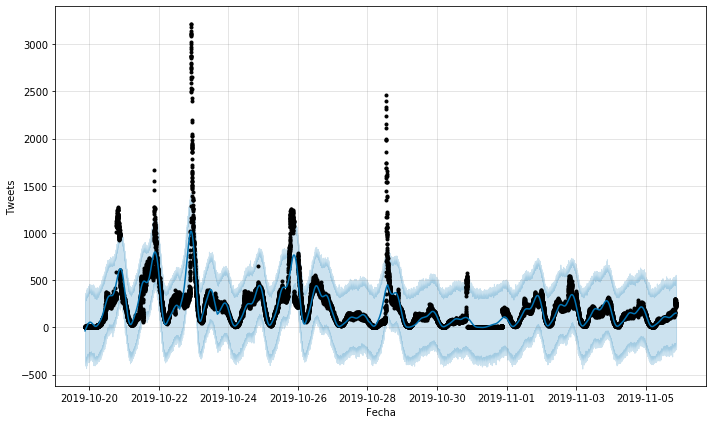

In [5]:
m.plot(forecast, xlabel='Fecha', ylabel='Tweets', uncertainty=True, plot_cap=True)
plt.show()

Este siguiente plot nos permite ver los momentos en los que se produjeron cambios de tendencia en la cantidad de tweets escritos por minuto.

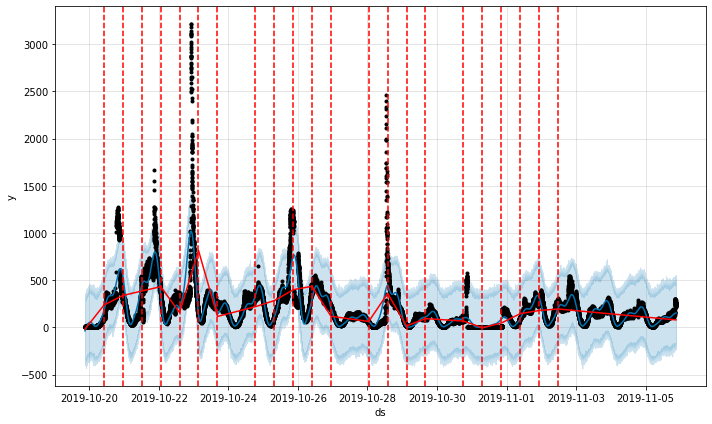

In [6]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# ANOMALÍAS DETECTADAS

Se detectaron **6 eventos** en los que el tráfico en twitter se comportó de forma **anómala**, a continuación detallaremos nuestros descubrimientos en algunos de estos eventos.

###	Contexto:

- **21 de Octubre:** Arrecian las críticas a la declaración de Piñera sobre estar "en guerra". El general Iturriaga afirma que "no estoy en guerra con nadie".  
- **22 de Octubre:** En cadena nacional, el Presidente Sebastián Piñera hace un mea culpa y anuncia un paquete de medidas de corte social para enfrentar la crisis
- **23 de Octubre:** El ministro del Interior, Andrés Chadwick, asiste a la Cámara de Diputados, donde defendió la decisión de decretar estado de emergencia en distintas zonas del país y afirma que "la democracia no acepta violencia".  
- **25 de Octubre:** A una semana del estallido social, cuatro fiscalías metropolitanas indagan en conjunto los ataques a las estaciones.  Por la tarde en Santiago, unas 1.200.000 personas repletan Plaza Italia y se manifiestan contra la inequidad, las bajas pensiones, el crédito CAE y otras consignas.
- **28 de Octubre:** Piñera realiza un importante cambio de gabinete, donde ocho ministerios cambian de titular y cinco figuras salen de La Moneda.
- **30 de Octubre:** Cerca de las 11:00 de la mañana, a 17 días de la APEC y un mes de la COP 25, Piñera anuncia "con mucho dolor" la suspensión de ambos eventos

Fuente: Emol.com - https://www.emol.com/noticias/Nacional/2019/11/08/966621/Cronologia-Tres-semanas-crisis-Chile.html

![anomalia 01](https://raw.githubusercontent.com/connectalabs/riots_chile_analisis/master/plots/ts_anomaly_mark.png)

## Anomalía #1 | 2019-10-21

Se encontraron **15.781 tweets escritos que considerados anómalos** por el análisis de serie de tiempo, los principales hashtags utilizados fueron:

| Hashtag | Q Tweets |
|--|--|
| renunciapinera | 6215 |
| pinerarenuncia |  5648 |
| chiledesperto | 1965  |
| noestamosenguerra |  707 |

Las principales palabras conversadas por esos tweets.

![anomalia 01](https://raw.githubusercontent.com/connectalabs/riots_chile_analisis/master/plots/wc_anomalia_01.png)

## Anomalía #3 | 2019-10-23

Se encontraron **177.211 tweets escritos que considerados anómalos** por el análisis de serie de tiempo, los principales hashtags utilizados fueron:

| Hashtag | Q Tweets |
|--|--|
| renunciapinera | 155143 |
| pinerarenuncia |  10400 |
| chiledesperto | 6749  |
| noestamosenguerra |  1298 |

Las principales palabras conversadas por esos tweets.

![anomalia 01](https://raw.githubusercontent.com/connectalabs/riots_chile_analisis/master/plots/wc_anomalia_02.png)

## Anomalía #5 | 2019-10-28

Se encontraron **86.303 tweets escritos que considerados anómalos** por el análisis de serie de tiempo, los principales hashtags utilizados fueron:

| Hashtag | Q Tweets |
|--|--|
| cambiodegabinete | 79417 |
| renunciapinera |  2894 |
| chiledesperto | 1591  |
| nuevaconstitucion |  1225 |

Las principales palabras conversadas por esos tweets.

![anomalia 02](https://raw.githubusercontent.com/connectalabs/riots_chile_analisis/master/plots/wc_anomalia_03.png)

# CONCLUSIONES

**Pudimos confirmar que existe tráfico anómalo /fuera de lo normal en Twitter**, al parecer tiene como fin el influenciar a la opinión pública, se ven claramente peaks de tráfico que están fuera del comportamiento normal de la muestra.

No podemos concluir fehacientemente que este tráfico anómalo sea generado por bot´s, ya que el API de Twitter no nos permite identificar con certeza, que cuentas en específico podrían ser bot´s, o parte de una campaña coordinada de desinformación. La interfaz programática de Twitter impone muchas limitaciones a lo que se puede hacer al analizar una cuenta. Por ejemplo, de manera predeterminada, solo se pueden recopilar los últimos 3200 tweets de una cuenta en específico, y Twitter restringe la frecuencia con la que se puede ejecutar dicha consulta. La mayoría de las cuentas potencialmente sospechosas identificadas durante esta investigación han publicado decenas, o incluso cientos de miles de tweets a lo largo de su vida, la mayoría de los cuales ahora son inaccesibles.